In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.preprocessing import RobustScaler
from pathlib import Path
import traceback
import warnings

# 全局配置
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [5]:
# ==================== 数据预处理模块 ====================
class DataPreprocessor:
    """数据预处理"""
    
    def __init__(self, raw_data):
        self.raw = raw_data.copy()
        self.data = None
        
    def process(self):
        """执行完整清洗流程"""
        try:
            print("▶ 阶段1/7：验证输入数据...")
            self._validate_input()
            
            print("▶ 阶段2/7：处理时间序列...")
            self._convert_datetime()
            
            print("▶ 阶段3/7：优化数据类型...")
            self._convert_dtypes()
            
            print("▶ 阶段4/7：处理重复值...")
            self._handle_duplicates()
            
            print("▶ 阶段5/7：计算收益率...")
            self._calculate_returns()
            
            print("▶ 阶段6/7：处理异常值...")
            self._handle_outliers()
            
            print("▶ 阶段7/7：填充缺失值...")
            self._impute_missing()
            
            self._final_check()
            print("✓ 数据预处理完成")
            return self.data
        except Exception as e:
            traceback.print_exc()
            raise RuntimeError(f"数据预处理失败: {str(e)}")

    def _validate_input(self):
        """验证输入数据完整性"""
        required_cols = {'date', 'open', 'high', 'low', 'close', 'volume'}
        missing = required_cols - set(self.raw.columns)
        if missing:
            raise KeyError(f"缺失必要字段: {missing}")
            
        if self.raw.isnull().all().any():
            raise ValueError("存在全空字段，请检查数据源")

    def _convert_datetime(self):
        """时间序列处理"""
        self.raw['date'] = pd.to_datetime(self.raw['date'], utc=True)
        self.raw = self.raw.sort_values('date').set_index('date')
        self.raw = self.raw.asfreq('D', method='ffill')

    def _convert_dtypes(self):
        """数值类型优化"""
        numeric_cols = ['open', 'high', 'low', 'close', 'volume']
        self.raw[numeric_cols] = self.raw[numeric_cols].astype(np.float32)

    def _handle_duplicates(self):
        """处理重复时间戳"""
        dup_mask = self.raw.index.duplicated(keep='first')
        self.raw = self.raw[~dup_mask]

    def _calculate_returns(self):
        """收益率计算（多层保护）"""
        # 价格插值
        self.raw['close'] = self.raw['close'].interpolate()
        
        # 简单收益率
        self.raw['returns'] = self.raw['close'].pct_change().fillna(0)
        
        # 对数收益率（三重保护）
        with np.errstate(divide='ignore', invalid='ignore'):
            log_ret = np.log(self.raw['close']) - np.log(self.raw['close'].shift(1))
            log_ret = log_ret.replace([np.inf, -np.inf], np.nan)
            self.raw['log_returns'] = log_ret.ffill().bfill().fillna(0)

    def _handle_outliers(self):
        """改进的异常值处理"""
        for col in ['open', 'high', 'low', 'close', 'volume']:
            q1 = self.raw[col].quantile(0.05)
            q3 = self.raw[col].quantile(0.95)
            self.raw[col] = np.clip(self.raw[col], q1, q3)

    def _impute_missing(self):
        """多重插值策略"""
        price_cols = ['open', 'high', 'low', 'close']
        self.raw[price_cols] = self.raw[price_cols].interpolate(method='linear', limit_direction='both')
        self.raw['volume'] = self.raw['volume'].ffill().bfill()

    def _final_check(self):
        """最终数据校验"""
        self.raw = self.raw.dropna(subset=['returns', 'log_returns'], how='any')
        missing = self.raw.isnull().sum()
        
        if missing.sum() > 0:
            raise ValueError(f"残留缺失值:\n{missing[missing > 0]}")
        print(f"数据样本量: {len(self.raw)} 条")
        self.data = self.raw.copy()

In [6]:
# ==================== ALPHA因子生成模块 ====================
class Alpha101Generator:
    """ALPHA101因子生成器"""
    
    def __init__(self, clean_data):
        self.data = clean_data.copy()
        self.factors = pd.DataFrame(index=self.data.index)
        self.epsilon = 1e-7
        
    def generate_factors(self):
        """生成并分析ALPHA因子"""
        try:
            # 因子计算
            print("\n▶ 生成ALPHA#1: 波动率调整动量...")
            self._alpha_1()
            
            print("▶ 生成ALPHA#4: 量价背离因子...")
            self._alpha_4()
            
            print("▶ 生成ALPHA#5: 收益率秩相关...")
            self._alpha_5()
            
#             print("▶ 生成ALPHA#6: 波动率时序变化...")
#             self._alpha_6()
            
            print("▶ 生成ALPHA#8: 加权收盘价变化...")
            self._alpha_8()
            
            print("▶ 生成ALPHA#12: 量价趋势背离...")
            self._alpha_12()
            
            print("▶ 生成ALPHA#23: 高频反转因子...")
            self._alpha_23()
            
            print("▶ 生成ALPHA#32: 波动率调整收益...")
            self._alpha_32()
            
            print("▶ 生成ALPHA#45: 动量持续强度...")
            self._alpha_45()
            
            print("▶ 生成ALPHA#67: 流动性调整动量...")
            self._alpha_67()
            
            # 后处理
            print("\n▶ 执行因子后处理...")
            factors_clean = self._postprocessing()
            
            # 相关性分析
            print("▶ 生成相关性分析...")
            self._analyze_correlation(factors_clean)
            
            return factors_clean
            
        except Exception as e:
            traceback.print_exc()
            raise RuntimeError(f"因子生成失败: {str(e)}")

    def _postprocessing(self):
        """因子后处理"""
        print("阶段1/2：处理极端值...")
        # 第一层：Z-Score过滤
        for col in self.factors.columns:
            with np.errstate(divide='ignore', invalid='ignore'):
                z_scores = np.abs((self.factors[col] - self.factors[col].mean()) / self.factors[col].std())
                self.factors[col] = self.factors[col].mask(z_scores > 5, np.nan)
        
        print("阶段2/2：稳健标准化...")
        # 第二层：无限值防护
        self.factors.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.factors = self.factors.ffill().bfill()
        
        # 标准化
        scaler = RobustScaler(with_centering=True, 
                             with_scaling=True,
                             quantile_range=(5.0, 95.0))
        scaled = scaler.fit_transform(self.factors)
        return pd.DataFrame(scaled, columns=self.factors.columns, index=self.factors.index)

    def _analyze_correlation(self, factors):
        """因子相关性分析"""
        corr_matrix = factors.corr().round(2)
        
        plt.figure(figsize=(14, 12), dpi=100)
        sns.heatmap(
            corr_matrix, 
            annot=True,
            fmt=".2f",
            cmap="RdBu",
            center=0,
            linewidths=0.5,
            annot_kws={"size": 9},
            cbar_kws={"shrink": 0.8}
        )
        plt.title('ALPHA因子相关系数热力图', fontsize=14, pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
        plt.tight_layout()
        plt.savefig('factor_correlation.png', dpi=300, bbox_inches='tight')
        plt.close()
    # ----------------- ALPHA因子实现-----------------
    def _alpha_1(self):
        """ALPHA#1: 波动率调整动量"""
        ret = self.data['returns']
        vol = ret.rolling(20, min_periods=10).std().clip(lower=self.epsilon)
        adj_momentum = ret.rolling(5, min_periods=3).mean() / vol
        self.factors['Alpha1'] = adj_momentum.rank(pct=True)

    def _alpha_4(self):
        """ALPHA#4: 量价背离因子"""
        price_rank = self.data['close'].rolling(5).apply(
            lambda x: (rankdata(x)[-1]/len(x)) if len(x)==5 else np.nan
        )
        volume_rank = self.data['volume'].rolling(5).apply(
            lambda x: (rankdata(x)[-1]/len(x)) if len(x)==5 else np.nan
        )
        self.factors['Alpha4'] = (price_rank - volume_rank).rolling(10).mean()

    def _alpha_5(self):
        """ALPHA#5: 收益率秩相关"""
        ret_rank = self.data['returns'].rolling(10).apply(
            lambda x: (rankdata(x)[-1]/len(x)) if len(x)==10 else np.nan
        )
        vol_rank = self.data['volume'].rolling(10).apply(
            lambda x: (rankdata(x)[-1]/len(x)) if len(x)==10 else np.nan
        )
        self.factors['Alpha5'] = ret_rank.rolling(10).corr(vol_rank)


    def _alpha_8(self):
        """ALPHA#8: 加权收盘价变化"""
        weighted_close = (self.data['close'] * 0.5 + 
                         self.data['high'] * 0.25 + 
                         self.data['low'] * 0.25)
        self.factors['Alpha8'] = weighted_close.pct_change(3).rank(pct=True)

    def _alpha_12(self):
        """ALPHA#12: 量价趋势背离"""
        price_trend = self.data['close'].rolling(10).mean() / (self.data['close'].shift(10) + self.epsilon)
        volume_trend = self.data['volume'].rolling(10).mean() / (self.data['volume'].shift(10) + self.epsilon)
        self.factors['Alpha12'] = (price_trend - volume_trend).rank(pct=True)

    def _alpha_23(self):
        """ALPHA#23: 高频反转因子"""
        ret_3 = self.data['returns'].rolling(3, min_periods=2).mean()
        ret_10 = self.data['returns'].rolling(10, min_periods=5).mean()
        self.factors['Alpha23'] = (ret_3 - ret_10).rank(pct=True)

    def _alpha_32(self):
        """ALPHA#32: 波动率调整收益"""
        vol = self.data['close'].rolling(20, min_periods=10).std().clip(lower=self.epsilon)
        adj_ret = self.data['returns'].rolling(5, min_periods=3).mean() / vol
        self.factors['Alpha32'] = adj_ret.rank(pct=True)

    def _alpha_45(self):
        """ALPHA#45: 动量持续强度"""
        mom_10 = self.data['close'].pct_change(10).replace([np.inf, -np.inf], 0)
        mom_30 = self.data['close'].pct_change(30).replace([np.inf, -np.inf], 0)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = (mom_10 - mom_30) / (np.abs(mom_30) + self.epsilon)
        self.factors['Alpha45'] = ratio.rank(pct=True)

    def _alpha_67(self):
        """ALPHA#67: 流动性调整动量"""
        liq = self.data['volume'].rolling(20, min_periods=10).mean().clip(lower=1)
        adj_mom = self.data['close'].pct_change(20) * np.log1p(liq)
        self.factors['Alpha67'] = adj_mom.rank(pct=True).replace([np.inf, -np.inf], 0)


In [7]:
# ==================== 回测模块 ====================
class Backtester:
    """因子回测分析模块"""
    
    def __init__(self, factors, price_data):
        """
        参数:
        factors : 生成的因子矩阵 (DataFrame)
        price_data : 包含收益率的原始数据 (DataFrame)
        """
        self.factors = factors.copy()
        self.returns = price_data['returns'].reindex(factors.index)
        self.factor_returns = None
        
    def run_backtest(self):
        """执行完整回测流程"""
        print("\n▶ 开始回测分析...")
        self._calculate_factor_returns()
        sharpe_ratios = self._calculate_sharpe_ratios()
        cumulative_returns = self._calculate_cumulative_returns()
        
        # 生成报告
        report = pd.DataFrame({
            'Sharpe': sharpe_ratios,
            'Cumulative_Return': cumulative_returns
        })
        
        # 可视化结果
        self._plot_results(cumulative_returns)
        return report

    def _calculate_factor_returns(self):
        """改进的收益率计算"""
        # 严格数据对齐
        aligned_returns = self.returns.shift(-1).dropna()
        valid_dates = aligned_returns.index.intersection(self.factors.index)
        self.factor_returns = self.factors.loc[valid_dates].multiply(
            aligned_returns.loc[valid_dates], axis=0
        )
        
        # 异常值过滤
        self.factor_returns = self.factor_returns.clip(
            lower=self.factor_returns.quantile(0.01),
            upper=self.factor_returns.quantile(0.99),
            axis=1
        )

    def _calculate_sharpe_ratios(self):
        """计算年化夏普比率"""
        annual_factor = np.sqrt(252)  # 年化系数
        mean_returns = self.factor_returns.mean()
        std_returns = self.factor_returns.std()
        return (mean_returns / std_returns) * annual_factor

    def _calculate_cumulative_returns(self):
        """计算累计收益率"""
        return (1 + self.factor_returns).cumprod().iloc[-1] - 1

    def _plot_results(self, cumulative_returns):
        """改进的可视化方法"""
        plt.figure(figsize=(14, 6))
        plt.subplots_adjust(top=0.85, wspace=0.3)  # 调整布局
        
        # 左图：累计收益率
        plt.subplot(1, 2, 1)
        sns.barplot(
            x=cumulative_returns.index, 
            y=cumulative_returns.values,
            palette="viridis"
        )
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.title('因子累计收益率', fontsize=10, pad=20)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
        
        # 右图：净值曲线
        plt.subplot(1, 2, 2)
        cum_net = (self.factor_returns + 1).cumprod()
        for col in cum_net.columns:
            plt.plot(cum_net[col], alpha=0.7, label=col ,  linewidth=1.5)
        plt.title('因子净值曲线 (对数坐标)', fontsize=10, pad=20)
#         plt.yscale('log')  # 对数坐标
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        plt.suptitle('因子绩效分析报告', fontsize=12, y=0.95)
        plt.savefig('factor_performance.png', dpi=300, bbox_inches='tight')

In [8]:
# ==================== 主执行程序 ====================
def main():
    try:
        # 配置路径
        input_path = Path(r"C:\Users\cuixinpu\pingan.csv")
        output_dir = Path(r"C:\Users\cuixinpu\alpha101_results")
        output_dir.mkdir(exist_ok=True, parents=True)
        
        # 加载原始数据
        print(f"\n▶ 正在加载数据: {input_path}")
        raw_df = pd.read_csv(
            input_path,
            parse_dates=['date'],
            dtype={'volume': np.float64},
            na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-nan']
        )
        
        # 数据预处理
        print("\n▶ 执行数据预处理...")
        processor = DataPreprocessor(raw_df)
        clean_data = processor.process()
        clean_data.to_parquet(output_dir / "cleaned_data.parquet")
        print(f"✓ 清洗数据已保存至: {output_dir/'cleaned_data.parquet'}")
        
        # 生成ALPHA因子
        print("\n▶ 生成ALPHA101因子...")
        generator = Alpha101Generator(clean_data)
        factors = generator.generate_factors()
        # 执行回测分析
        print("\n▶ 执行回测分析...")
        backtester = Backtester(factors, clean_data)
        backtest_report = backtester.run_backtest()
        
        # 合并报告
        full_report = pd.concat([
            factors.describe().T,
            backtest_report
        ], axis=1)
        
        # 保存结果
        report_path = output_dir / "full_factor_report.csv"
        full_report.to_csv(report_path)
        print(f"✓ 完整报告已保存至: {report_path}")

        # 最终校验
        print("\n✓ 处理完成，回测结果摘要：")
        print(full_report[['mean', 'Sharpe', 'Cumulative_Return']].round(2))


    except Exception as e:
        print(f"\n❌ 运行错误: {str(e)}")
        print("故障排查建议:")
        print("1. 检查输入文件路径是否正确")
        print("2. 确认数据包含足够的交易日")



▶ 正在加载数据: C:\Users\cuixinpu\pingan.csv

▶ 执行数据预处理...
▶ 阶段1/7：验证输入数据...
▶ 阶段2/7：处理时间序列...
▶ 阶段3/7：优化数据类型...
▶ 阶段4/7：处理重复值...
▶ 阶段5/7：计算收益率...
▶ 阶段6/7：处理异常值...
▶ 阶段7/7：填充缺失值...
数据样本量: 1116 条
✓ 数据预处理完成
✓ 清洗数据已保存至: C:\Users\cuixinpu\alpha101_results\cleaned_data.parquet

▶ 生成ALPHA101因子...

▶ 生成ALPHA#1: 波动率调整动量...
▶ 生成ALPHA#4: 量价背离因子...
▶ 生成ALPHA#5: 收益率秩相关...
▶ 生成ALPHA#8: 加权收盘价变化...
▶ 生成ALPHA#12: 量价趋势背离...
▶ 生成ALPHA#23: 高频反转因子...
▶ 生成ALPHA#32: 波动率调整收益...
▶ 生成ALPHA#45: 动量持续强度...
▶ 生成ALPHA#67: 流动性调整动量...

▶ 执行因子后处理...
阶段1/2：处理极端值...
阶段2/2：稳健标准化...
▶ 生成相关性分析...

▶ 执行回测分析...

▶ 开始回测分析...
✓ 完整报告已保存至: C:\Users\cuixinpu\alpha101_results\full_factor_report.csv

✓ 处理完成，回测结果摘要：
         mean  Sharpe  Cumulative_Return
Alpha1  -0.00   -1.07              -0.23
Alpha4  -0.03    0.24               0.05
Alpha5  -0.01    0.87               0.22
Alpha8  -0.04   -0.46              -0.12
Alpha12 -0.00   -0.36              -0.09
Alpha23 -0.00   -0.51              -0.13
Alpha32 -0.00   -1.06              -0.23

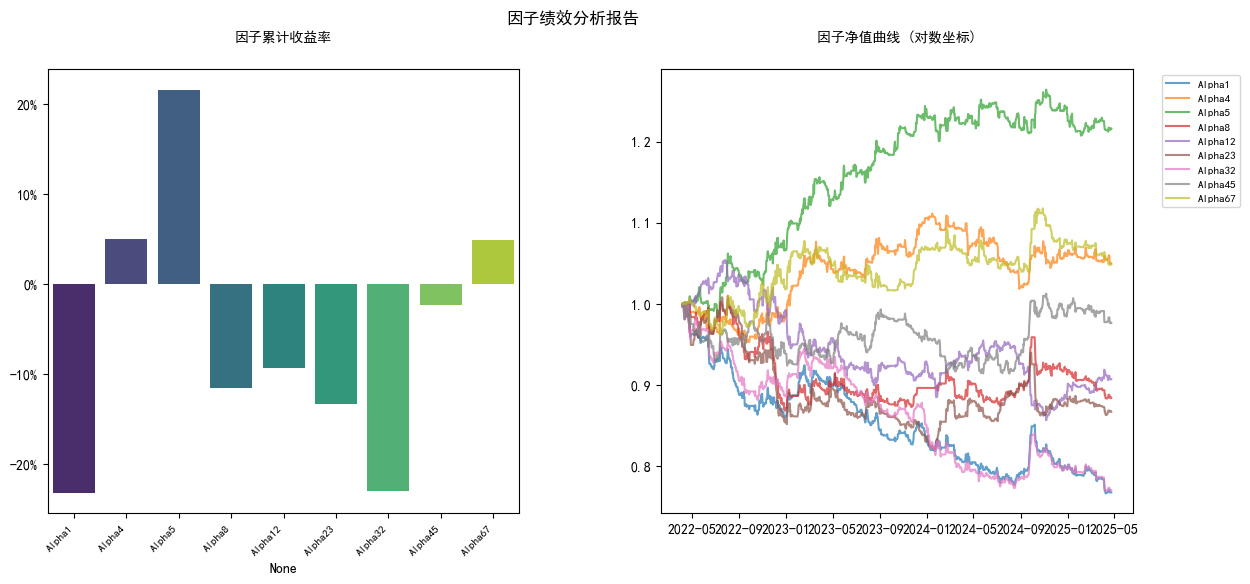

In [9]:
if __name__ == "__main__":
    main()